# Author: Sumit Sarin

SUMMARY:<br>
* kaggle submission: https://www.kaggle.com/stellargo/three3tres
* This is a multilabel classification problem. Hence, classes are encoded with binary values, each class gets a column containing truth value depicting if the image belongs to the label or not.
* The dataset comprises of Images. Images have a large no of features, deep learning is particularly suited for these kinds of tasks. 
* Since images have a lot of local information, we can make do with lesser number of weights than a fully connected layer by using a CNN.
* I tried two popular CNN architectures used in image classification: VGG16 and ResNet50. VGG gave slightly better results as it reached lower loss more quickly.
* There is a huge class imbalance. Some labels occur on more than 37512 images, while some occur on as low as 99.
* Hence, I did not make a validation and train split, because some classes/combinations in that case may never appear in the training data due to randomness of split.
* Instead, I used cross validation, and Out Of Fold(OOF) Approach. For every iteration of cross validation, I opbtained the sigmoid values on the test set and then averaged them all.
* Also, I used sigmoid activation in the output layer because softmax gives log probability distribution and hence is not used in multilabel classification problems.
* Higher resolution images will contain more data and give better results. But it takes a toll on the memory. Hence I generate data in batches using the ImageDataGenerator class provided by keras.
* I track F2 scores of the validation set after each epoch, and save the best F2 scores model for each cross validation iteration.
* I also used data augmentation, which involved horizontal and vertical shifting, and flipping, both horizontally and vertically.
* The images were normalized to the scale of 0 to 1.
* I tuned the hyperparameters and was able to achieve an F2 score of 0.92523 on the public set and 0.92374 on the private set.

##### IMPORTS

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

from tensorflow.keras.layers import Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.backend import clear_session
import tensorflow as tf

##### Hyperparameters, etc.

In [2]:
INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
DROPOUT_RATE = 0.5
EPOCHS = 24
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
NFOLDS = 5 # No of folds for cross validation
WORKERS = 4 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

TRAIN_PATH = '/kaggle/input/planet-understanding-the-amazon-from-space/train-jpg'
TEST_PATH = '/kaggle/input/planet-understanding-the-amazon-from-space/test-jpg-v2'

TRAIN_CSV_PATH = '/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv'
TEST_CSV_PATH = '/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv'

##### Construct dataframes holding training and test data information

In [3]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str) + '.jpg'
df_test['image_name'] = df_test['image_name'].astype(str) + '.jpg'

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

print(df_train.head())
print(df_test.head())

X_train_files = np.array(df_train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))

y_train = np.array(df_train['tags'].tolist())

    image_name                                       tags
0  train_0.jpg                               haze primary
1  train_1.jpg            agriculture clear primary water
2  train_2.jpg                              clear primary
3  train_3.jpg                              clear primary
4  train_4.jpg  agriculture clear habitation primary road
   image_name                                        tags
0  test_0.jpg  [primary, clear, agriculture, road, water]
1  test_1.jpg  [primary, clear, agriculture, road, water]
2  test_2.jpg  [primary, clear, agriculture, road, water]
3  test_3.jpg  [primary, clear, agriculture, road, water]
4  test_4.jpg  [primary, clear, agriculture, road, water]


##### Create list of all labels in the data

In [4]:
labels = []

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
        
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


##### Plot a few images and their labels. The images are 256x256. Below we see quality of images on 32x32, 64x64, 128x128, 256x256 resolutions.

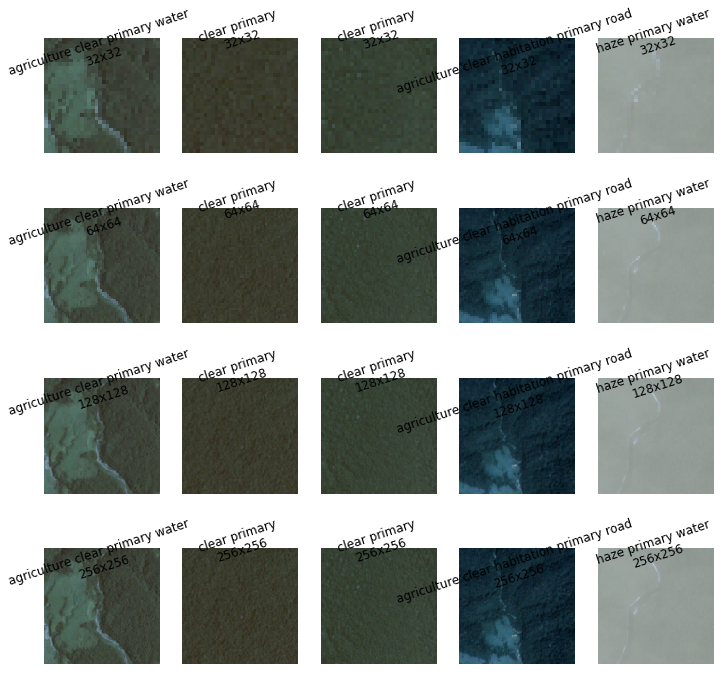

In [5]:
plt.figure(figsize=(12, 12))
res = [32, 64, 128, 256]
NIMGS = 5

for i in range(len(res)):
    for j in range(NIMGS):
        img = cv2.imread(os.path.join(TRAIN_PATH,df_train['image_name'][j+1]))
        img = cv2.resize(img, (res[i], res[i]))
        plt.subplot(len(res), NIMGS, i*NIMGS+j+1)
        plt.imshow(img)
        plt.title(df_train['tags'][j+1] + "\n" + str(res[i]) + "x" + str(res[i]), rotation=18)
        plt.axis('off')
    
plt.show()

##### INFERENCE:
* In 32 bit resolution, it's hard for even me to make out that a road is present in 4th column.
* The presence of water (or a wave?) in column 5 is unclearish (broken) in 64 bit, while it becomes clear in 128 bit and 256 bit images.
* In 128 bit and 256 bit, there isnt much of a difference. Plus the added cost of more training time (and memory) wouldnt be worthwile I think.
* Hence I believe 128 bit resolution is a good bet.

##### Plot counts of each label

conventional_mine is tagged least no of times: 99
primary is tagged max no of times: 37512


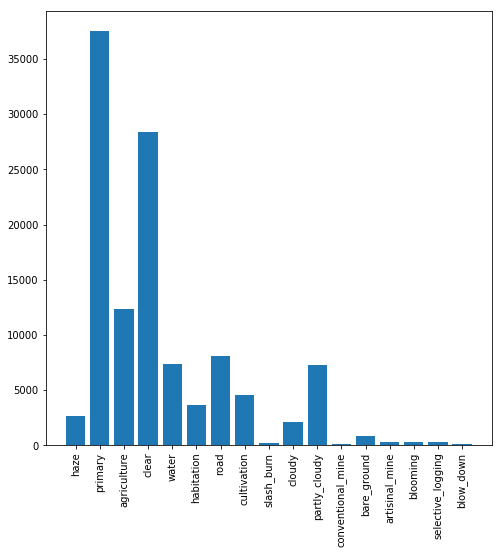

In [6]:
plt.figure(figsize=(8, 8))

labels_count = {}

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
min_label = min(labels_count, key=labels_count.get)
max_label = max(labels_count, key=labels_count.get)
print(min_label+" is tagged least no of times: "+str(labels_count[min_label]))
print(max_label+" is tagged max no of times: "+str(labels_count[max_label]))
            
plt.bar(range(len(labels_count)), list(labels_count.values()), align='center')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation=90)

plt.show()

##### INFERENCE:
* Because some classes have too few labels, it is possible that if I split into training and validation set, some classes may get entirely lost from one of the sets. This would be bad.
* Hence it's best to use cross validation here, and using OOF would ensure that we are protected from the above problem.
* In OOF what we do is basically take predictions on test set from model trained on each fold of cross validation, and average them out.
* Accuracy is a bad metric here, and hence F2 is being used.

##### Function to create the CNN model.
* Earlier I had included two dense layers at the end, but I found that there was no improvement being offered by them in terms of results, and were taking more memory.
* I tried two different popular architectures: VGG16 and ResNet50 with weights trained on Imagenet dataset. The weights were finetuned on our dataset.

In [7]:
def create_model():
    model = Sequential()
    model.add(InputLayer(INPUT_SHAPE))
    model.add(VGG16(weights='imagenet', include_top=False))
    model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(DROPOUT_RATE))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(17, activation='sigmoid'))
    return model

clear_session()

model = create_model()
model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 17)                139281    
Total params: 14,853,969
Trainable params: 14,853,969
Non-trainable params: 0
_________________________________________________________________


##### Callback function so I can measure the F2 score of the validation set after every epoch and save the best model accordingly.

In [8]:
def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

##### Here, I iterate through each fold, 
* I generate batches of training, validation and test data using generators. This allows me to fit the data in the memory.
* Each batch is normalized to a scale of 0 to 1 across all three channels. The resolution is also decreased (128x128).
* Data augmentation is applied in the form of horizontal/vertical shifts and horizontal/vertical flipping.
* I use multithreading so that multiple threads can generate batches and add them to a queue, on which forward and backward pass are performed sequentially. This is done to give a boost to the slower disk speeds.
* I used Adam optimizer. (tried SGD with momentum also but Adam gave better results)
* Applied an automatic decrease on the learning rate if training loss hits a plateau.

In [9]:
num_fold = 0

y_test = []

folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=1).split(X_train_files, y_train)

for train_index, val_index in folds:
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])
    
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=TEST_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        shuffle=False,
    )

    model_path_of_fold = os.path.join('', 'weights_of_fold_' + str(num_fold) + '.h5')
    
    clear_session()
    model = create_model()
    
    adam = Adam(learning_rate=LR)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f2_score])
    
    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='val_f2_score', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]
    
    model.fit_generator(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                       workers=WORKERS, use_multiprocessing=True, max_queue_size=MAXQ)

    model.load_weights(model_path_of_fold)

    p_test = model.predict_generator(test_generator, workers=WORKERS, use_multiprocessing=True, max_queue_size=MAXQ)
    y_test.append(p_test)

Found 32383 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Found 61191 validated image filenames belonging to 17 classes.
Epoch 1/24
253/253 [==============================] - 248s 981ms/step - loss: 0.1521 - f2_score: 0.8068 - val_loss: 0.1137 - val_f2_score: 0.8792
Epoch 2/24
253/253 [==============================] - 225s 889ms/step - loss: 0.1168 - f2_score: 0.8605 - val_loss: 0.1062 - val_f2_score: 0.8831
Epoch 3/24
253/253 [==============================] - 227s 899ms/step - loss: 0.1076 - f2_score: 0.8727 - val_loss: 0.1089 - val_f2_score: 0.8847
Epoch 4/24
253/253 [==============================] - 229s 907ms/step - loss: 0.1037 - f2_score: 0.8778 - val_loss: 0.0985 - val_f2_score: 0.8972
Epoch 5/24
253/253 [==============================] - 221s 875ms/step - loss: 0.1016 - f2_score: 0.8810 - val_loss: 0.0988 - val_f2_score: 0.8867
Epoch 6/24
253/253 [==============================] - 226s 894ms/step - loss: 0.09

##### Take average of all predictions (OOF) generated during each fold of validation on the test set, and attach predictions to the test dataframe.

In [10]:
result = np.array(y_test[0])
for i in range(1, NFOLDS):
    result += np.array(y_test[i])
result /= NFOLDS
result = pd.DataFrame(result, columns = labels)
result.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.007389,0.000005,0.000079,0.078188,0.000393,0.994739,1.055002e-06,9.357929e-07,0.004303,0.001527,0.001851,0.002066,0.999995,0.002857,0.005840,0.000042,0.004196
1,0.024593,0.000019,0.000492,0.021235,0.006809,0.997270,1.192093e-07,2.324581e-06,0.023933,0.001914,0.000157,0.001806,0.999999,0.002292,0.006984,0.000226,0.002876
2,0.042864,0.000053,0.000946,0.000505,0.002208,0.000062,4.017949e-05,1.001596e-04,0.014540,0.002135,0.000026,0.999860,0.999961,0.015707,0.000852,0.000283,0.067385
3,0.660432,0.000072,0.001694,0.020907,0.000734,0.895082,2.264976e-07,1.776218e-05,0.623988,0.005245,0.000697,0.145168,0.999999,0.020583,0.004259,0.001800,0.046680
4,0.022809,0.000011,0.000336,0.000018,0.000051,0.000531,1.666338e-01,1.418591e-06,0.007548,0.001361,0.000925,0.897370,0.854890,0.008562,0.000027,0.000007,0.035566


##### Construct the csv file of predictions on test set, convert the binary labels to their respective labels.

In [11]:
preds = []
for i in range(result.shape[0]):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
    
df_test['tags'] = preds
df_test['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
df_test.to_csv('submit.csv', index=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
